# Goals
- [x] Get ebird data from Alex
    - [x] US only (18g Feb17)
    - [ ] Update US data (18g Feb17 -> 20g May18) so it isn't a truncated gz
    - [ ] Try on global data (18g -> 29g -- turns out checklists are dominated by US)
- [ ] ebird.predict_proba(loc, date) -> probs
    - [x] Figure out how to aggregate to make data fit comfortably in mem
    - [x] Make an out-of-core ddf pass over the cols-for-time-space-priors.tsv file to produce the aggregates
    - [ ] Use the aggregates in memory to power the priors model
- [ ] Ensemble audio probs + ebird probs (expose tuning param for weighted combination)
- [ ] See how it improves model validation (e.g. many species should be way closer to few species)

In [ ]:
from notebooks import *

# Register a global dask progress bar
dask_progress().register()

relpath = os.path.relpath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# TODO -> features.util

In [ ]:
# Downsample raw data (in shell)
#   - TODO Downsample by checklist_id instead of line (one species within a checklist) to keep checklist (sampling
#     events) complete, else output priors are junk except for sample=1. This is nontrivial because we have to push the
#     full data volume through far enough to get checklist_id=coalesce(sampling_event_identifier, group_identifier)...
# (
#   set -eux
#   set -o pipefail
#   echo '
#     # 1              #  148m lines
#     # 1     .1 0.1   # 14.8m lines
#     # 0.1   .4 0.04  # 5.91m lines
#     # 0.04  .5 0.02  # 2.96m lines
#     # 0.1   .1 0.01  # 1.48m lines
#     # 0.01  .4 0.004 #  591k lines
#     # 0.004 .5 0.002 #  296k lines
#     # 0.01  .1 0.001 #  148k lines
#   ' | while read in_suf sample_frac out_suf comment; do
#     if [ -z "$in_suf" -o "$in_suf" = '#' ]; then continue; fi
#     raw_f='ebd_US_relFeb-2017.txt.gz'
#     in_f="$raw_f-$in_suf"; out_f="$raw_f-$out_suf"
#     cat "$in_f" \
#       | pv -terb -s"`du -Lhs "$in_f" | field 0`" -cN in \
#       | gunzip \
#       | sample-lines "$sample_frac" --seed=0 --keep-header \
#       | pigz \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# Inspect raw data
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz'        #  18gb,  148m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.1'    # 778mb, 14.8m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.01'   # 100mb, 1.48m lines
ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.001'  #  12mb,  148k lines
proj_cols = [
    'CATEGORY', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'COUNTY CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
    'SAMPLING EVENT IDENTIFIER', 'ALL SPECIES REPORTED',
]
ebd_tsv_df = pd.read_csv(ebd_tsv_path, sep='\t', nrows=10000, compression='gzip')
display(
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df))),
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df[proj_cols]))),
    # df_summary(ebd_tsv_df).T,
    df_summary(ebd_tsv_df[proj_cols]).T,
)

'9.9 MB'

'1.5 MB'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,80000,10000,10000,10000,NaN,NaN,0,2499,4999,7499,9999
CATEGORY,object,639319,10000,10000,7,NaN,NaN,domestic,species,species,species,spuh
SCIENTIFIC NAME,object,746281,10000,10000,608,NaN,NaN,Acanthis flammea,Charadrius semipalmatus,Lophodytes cucullatus,Sayornis phoebe,Zosterops japonicus
OBSERVATION COUNT,object,651101,10000,10000,163,NaN,NaN,1,1,3,X,X
COUNTY CODE,object,659150,10000,9975,1316,NaN,NaN,US-AK-013,US-FL-105,US-MI-077,US-OR-003,US-WY-039
LATITUDE,float64,80000,10000,10000,5304,NaN,NaN,19.1,35.6,39.8,42.3,71.4
LONGITUDE,float64,80000,10000,10000,5303,NaN,NaN,-172,-107,-88.1,-77.7,173
OBSERVATION DATE,object,670000,10000,10000,5557,NaN,NaN,1800-01-01,1989-04-30,1998-03-15,2002-06-15,2004-12-31
SAMPLING EVENT IDENTIFIER,object,655180,10000,10000,9883,NaN,NaN,S1000381,S16318134,S25555972,S4519111,S9998747


In [ ]:
# Convert ebd.txt -> proj.tsv (in shell)
#   - ~10x faster to read than raw data: no gunzip + fewer cols
# (
#   set -eux
#   set -o pipefail
#   sufs=(
#     # 0.001
#     # 0.002
#     # 0.004
#     # 0.01
#     # 0.02
#     # 0.04
#     # 0.1
#     # 1
#   )
#   for suf in "${sufs[@]}"; do
#     in_f="ebd_US_relFeb-2017.txt.gz-$suf"
#     out_f="derived/priors/ebd_US_relFeb-2017-1-proj.tsv-$suf"
#     cat "$in_f" \
#       | pv -terb -cN in -s"`du -Lhs "$in_f" | field 0`" \
#       | gunzip \
#       | cut -f4,6,9,17,25,26,27,32,39,40 \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# FIXME ebd_US_relFeb-2017.txt.gz looks truncated (maybe the original download didn't complete?)
#
#   # Convert ebd.txt -> proj.tsv (in shell)
#   $ ...
#   + in_f=ebd_US_relFeb-2017.txt.gz-1
#   + out_f=derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   ...
#         out: 11.6GiB 0:13:21 [11.3MiB/s]
#         out: 11.6GiB 0:13:21 [14.9MiB/s]
#   gunzip: (stdin): unexpected end of file
#
#   $ tail -3 derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   species Regulus calendula       2       US-OR-067       45.546725       -122.9678249    2012-03-07      S10112003       1
#   species Recurvirostra americana 13      US-UT-053       37.1810055      -113.7148046    2012-03-18      S10208648       0
#   species Passer domesticus       5       US-WI-097       44.4993598      -89.5568454     2012-01-19      S96324

In [ ]:
# %%snakeviz
# %%prun -l50 -scumtime
# Compute priors[week, geohash4, sci_name, n_present, n] <- priors[sci_name, date, loc]
#   - (week, geohash4): cheap map-side operations
#   - n_present: mid-weight groupby agg
#   - n: heavy windowed agg [overall bottleneck, super-linear]
# Resources:
#   - http://dask.pydata.org/en/latest/dataframe-api.html
#   - http://dask.pydata.org/en/latest/dataframe-performance.html
#   - http://dask.pydata.org/en/latest/dataframe.html
#   - http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.set_index

# sample = 1      #  148m lines,  18gb input, no_chk[?],    chk[1512  + 3713s]
# sample = 0.1    # 14.8m lines, 778mb input, no_chk[?],    chk[ 153  +   87s]
# sample = 0.04   # 5.91m lines, 350mb input, no_chk[?],    chk[?]
# sample = 0.02   # 2.96m lines, 189mb input, no_chk[?],    chk[?]
# sample = 0.01   # 1.48m lines, 100mb input, no_chk[19s],  chk[  16  +    5.0s]
# sample = 0.004  #  591k lines,  43mb input, no_chk[?],    chk[?]
# sample = 0.002  #  296k lines,  23mb input, no_chk[?],    chk[?]
sample = 0.001  #  148k lines,  12mb input, no_chk[2.1s], chk[  1.6 +    0.6s]

ebd_proj_size = 12 * 1024**3
ebd_proj_npartitions = 128
proj_path     = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-{sample}')
setindex_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-{sample}')
priors_path   = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors = (

    # Read proj.tsv (raw lines with subset of cols)
    #   - sample=0.001: 148k rows, 12mb
    dd.read_csv(
        proj_path,
        # TODO Tune partitions
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 10),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 100),
        blocksize=int(ebd_proj_size / ebd_proj_npartitions / 10),  # TODO This seems to work ok...?
        sep='\t',
        dtype={
            # lonlat decimal precision [https://en.wikipedia.org/wiki/Decimal_degrees]
            #   - float32: ~5-6 decimals, ~.1-1m
            #   - float16: ~1-2 decimals, ~1-10km
            'LATITUDE': 'float32',
            'LONGITUDE': 'float32',
            'OBSERVATION COUNT': 'str',  # int | 'X'
            'ALL SPECIES REPORTED': 'float16',  # Smallest dtype for {1, 0, None}
        },
    )
    # .pipe(puts, lambda ddf: 'len[%s]: read_csv' % len(ddf))  # Debug

    # Inspect [high-level perf debugging]
    .pipe(df_inspect, f'\n[read: {proj_path}]', lambda ddf: (
        f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        #     # TODO Add a dtype col to the memory_usage outputs
        #     # .pipe(lambda df: pd.concat(axis=1, objs=[
        #     #     df,
        #     #     ddf.reset_index().dtypes.to_frame().rename({'index': 'Index'}),  # TODO Make this not reorder the index
        #     # ]))
        # ),
    ))

    # Simplify col names
    .rename(columns=lambda c: c.lower().replace(' ', '_'))

    # Drop cols we don't need
    .drop(axis=1, labels=['county_code'])

    # Keep obs with well defined species [https://help.ebird.org/customer/portal/articles/1006825]
    #   - sample=0.001: 144k rows
    .pipe(lambda ddf: ddf[ddf.category.isin(['species', 'domestic', 'issf', 'form'])])
    .drop(axis=1, labels=['category'])
    # .pipe(puts, lambda ddf: 'len[%s]: categories.isin' % len(ddf))  # Debug

    # Keep obs from checklists that represent a complete sampling of all present species
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.all_species_reported == 1])
    .drop(axis=1, labels=['all_species_reported'])
    # .pipe(puts, lambda ddf: 'len[%s]: all_species_reported' % len(ddf))  # Debug

    # Map (sampling_event_identifier, group_identifier) -> checklist_id
    #   - sample=0.001: 125k rows
    #   - Compress from str to int32 ('S10150441' -> 10150441) for ~46% compression (e.g. 24mb -> 13mb)
    #   - Map sampling_event_identifier to pos ('S10150441' -> 10150441) and group_identifier to net ('G554362' -> -554362)
    #   - FIXME Some of these nulls are due to misaligned fields (maybe something funny in the tsv? nontrivial problem -- punt)
    .dropna(subset=['sampling_event_identifier'])
    .assign(checklist_id=lambda ddf: (ddf
        .group_identifier.combine_first(ddf.sampling_event_identifier)
        .str.replace('S', '').str.replace('G', '-').astype(np.int32)
    ))
    .drop(axis=1, labels=['sampling_event_identifier', 'group_identifier'])
    # .pipe(puts, lambda ddf: 'len[%s]: checklist_id' % len(ddf))  # Debug

    # Map (lat, lon) -> geohash4
    #   - sample=0.001: 125k rows
    #   - python-geohash
    #       - https://github.com/hkwi/python-geohash/wiki
    #       - https://github.com/hkwi/python-geohash/wiki/GeohashReference
    #   - How big is a geohash?
    #       - https://www.movable-type.co.uk/scripts/geohash.html [sf: (38,-122)]
    #       - https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash
    #   - Misc
    #       - https://en.wikipedia.org/wiki/Geohash
    #       - https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html
    .dropna(subset=['latitude', 'longitude'])
    .pipe(lambda ddf: ddf.map_partitions(
        meta=ddf._meta.assign(
            geohash4='',
        ),
        func=lambda df: df.assign(
            geohash4=lambda df: geohash_encode(df.latitude, df.longitude, 4),
        ),
    ))
    .drop(axis=1, labels=['latitude', 'longitude'])
    # .pipe(puts, lambda ddf: 'len[%s]: geohash4' % len(ddf))  # Debug

    # Keep obs with >0 observation_count (including 'X')
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.observation_count != '0'])
    .drop(axis=1, labels=['observation_count'])
    # .pipe(puts, lambda ddf: 'len[%s]: observation_count' % len(ddf))  # Debug

    # Assert our cols and drop any remaining nulls
    #   - sample=0.001: 125k rows
    .pipe(tap, lambda ddf: assert_(
        ddf.columns.tolist() == ['scientific_name', 'observation_date', 'checklist_id', 'geohash4'],
        'Unexpected cols: %s' % ddf.columns.tolist(),
    ))
    .dropna()
    # .pipe(puts, lambda ddf: 'len[%s]: dropna' % len(ddf))  # Debug

    # Map observation_date:str -> observation_week:uint8
    #   - (category would be more compact than uint32/64 in the .parquet, but that ran into problems -- abort)
    .assign(
        observation_date=lambda df: pd.to_datetime(df.observation_date),
        week=lambda df: ebird_week(df.observation_date.dt),
    )
    .astype({'week': np.uint8})
    .drop(axis=1, labels=['observation_date'])

    # Create categories to compact space usage via dictionary encoding
    #   - WARNING Have to recreate category dtypes after munging meta, else downstream .to_parquet fails on `pd.Index(None)`
    .astype({
        'scientific_name': 'category',
        'geohash4': 'category',  # Max 32**4 = ~1m values -> ~4mb dictionary (separate dictionary per partition df)
    })

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[map-side ops]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # .set_index to partition once to avoid 3 shuffles below (drop_duplicates, groupby, groupby)
    #   - ddf.set_index doesn't support multiple cols, so add dist_key = hash(week, geohash4)
    #   - Hash to uint16 for ≤64k partitions [alt: ≤256 for uint8]
    #   - [wontfix] uint16 gets unavoidably widened to uint64 by df.set_index [https://github.com/pandas-dev/pandas/issues/16404]
    .assign(dist_key=lambda df: (
        np_vectorize_asscalar(otypes=[np.uint16], pyfunc=lambda week, geohash4: (
            one(np.frombuffer(
                dtype=np.uint16,
                buffer=hashlib.sha1(f'{week}/{geohash4}'.encode('utf8')).digest()[:2],
            ))
        ))(df.week, df.geohash4)
    ))
    #   - Checkpoint before .set_index
    #       - Why helpful: the timing numbers above show a clean time-complexity split of linear before the chk and super-linear after
    .pipe(df_inspect, f'\n[checkpointing before set_index: {setindex_path}]')
    .pipe(ddf_checkpoint, setindex_path, compression=None,
        get=dask_get_for_scheduler('threads'),  # Procs no good [TODO why?]
        # resume_from_checkpoint=True,  # Re-comment out after measuring perf of .set_index
    )
    .pipe(df_inspect,
        f'\n[checkpointed before set_index: {setindex_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )
    #   - Finally do the .set_index
    .pipe(lambda ddf: (ddf
        .set_index('dist_key', divisions=ddf_divisions_for_dtype(ddf.dist_key.dtype,
            # TODO TODO Tune npartitions for groupby's
            # ddf.npartitions,
            # 1,   # sync+prun: 0.01[4.7s]
            # 2,   # sync+prun: 0.01[4.6s]
            # 5,   # sync+prun: 0.01[4.6s]
            10,  # sync+prun: 0.01[5.1s]
            # 20,  # sync+prun: 0.01[6.1s]
            # 40,  # sync+prun: 0.01[8.1s]
        ))
    ))
    #   - HACK Recreate category dtypes after the .set_index, else downstream .to_parquet fails on `pd.Index(None)`
    .pipe(lambda ddf: (ddf
        .astype({k: 'category' for k, v in ddf.dtypes.items() if v.name == 'category'})
    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[set_index(dist_key)]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # Do a bunch of map-side groupby's via .map_partitions, relying on the .set_index we just did
    .map_partitions(lambda df: (df

        # Drop duplicate rows since all (checklist, species) should be unique
        #   - sample=0.001: 142k -> 98.7k rows
        #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
        #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- definitely junk
        .drop_duplicates(
            subset=['week', 'geohash4', 'scientific_name', 'checklist_id'],
            keep='first',
        )

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: drop_duplicates]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n (window)
        #   - Num unique checklist_id's per (week, geohash4)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        #   - This assign-by-index is the bottleneck (way slower than the groupby for n_present)
        #       - See cell below for attempts at optimizing -- haven't found any faster approaches yet...
        .reset_index()  # dist_key, from ddf.map_partitions
        .set_index(['dist_key', 'week', 'geohash4'])
        .assign(n=lambda df: (df
            .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
            .checklist_id.nunique()
            .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
        ))

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n_present (group)
        #   - Num checklists per (week, geohash4, scientific_name)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        .assign(n_present=1)  # One per (week, geohash4, scientific_name, checklist_id)
        .groupby(observed=True, by=['dist_key', 'week', 'geohash4', 'scientific_name'])
        .agg({
            'n_present': 'sum',
            'n': 'first',  # Passthru; assume unique per group
            # Drop: checklist_id
        })

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n_present -> p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # XXX Keep (n_present, n) for simpler query-time aggregation
        # # Compute p, drop n_present
        # .assign(p=lambda df: (
        #     (df.n_present / df.n)
        #     .astype('float16')  # TODO uint8?
        #     # FIXME This turns into float32 after to_parquet
        #     #   - parquet doesn't support float16, so maybe it's getting coerced? [https://drill.apache.org/docs/parquet-format/]
        #     #   - TODO But does fastparquet read not re-cast to the dtype the .parquet file was written from?
        # ))
        # .drop(columns=['n_present'])
        # .pipe(df_reorder_cols, last=['n'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Restore dtypes lost in the index by the groupby's above (e.g. week: uint8 -> uint64)
        .reset_index()
        .astype({
            'week': 'uint8',
        })

        # Restore ['dist_key'] index for ddf.map_partitions
        .set_index(['dist_key'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: set_index]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[map_partitions]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
    )

    # Write
    #   - TODO df.to_parquet instead of ddf.to_parquet, since these files are only O(100mb) and ddf output isn't
    #     readable by pd, and pd.read_parquet() is ~15–30x faster than dd.read_parquet().compute()
    #   - Measurements for dd.read_parquet().compute() vs. pd.read_parquet()
    #       - sample = 1      # 330mb parquet, 177mb df,  13m rows, 8.0s ddf.read, .24s   df.read (!)
    #       - sample = 0.1    # 100mb parquet,  57mb df, 4.2m rows, 1.1s ddf.read, .069s  df.read
    #       - sample = 0.01   #  31mb parquet,  12mb df, 730k rows, .19s ddf.read, .0095s df.read
    #       - sample = 0.001  #   6mb parquet, 3.2mb df,  85k rows, .15s ddf.read, .0046s df.read
    .pipe(df_inspect, f'\n[write: {priors_path}]')
    .pipe(ddf_checkpoint, priors_path,
        compression=None,
        # get=dask_get_for_scheduler('synchronous'),  # Debug
        get=dask_get_for_scheduler('threads'),  # Faster
        # get=dask_get_for_scheduler('processes'),
    )

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[inspect priors: {priors_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        # Heavy [high-level perf debugging]
        '  [memory_usage by partition]',
        lambda ddf: (ddf
            .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
            .compute()
            .pipe(df_with_totals).reset_index()[:50]
        ),
    )
    .pipe(tap, lambda ddf: (ddf
        .head(10000)
        .pipe(df_inspect,
            lambda df: df_summary(df).T,
            lambda df: df[:10],
        )
    ))

)


[read: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-0.001]

'npartitions[2], divisions[(None, None, None)]'

,index,CATEGORY,SCIENTIFIC NAME,OBSERVATION COUNT,COUNTY CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,SAMPLING EVENT IDENTIFIER,ALL SPECIES REPORTED,GROUP IDENTIFIER
0,int64,object,object,object,object,float32,float32,object,object,float16,object



[map-side ops]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,geohash4,week
0,int64,category,int32,category,uint8



[checkpointing before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[####################                                                                      ] | 22% Completed |  0.1s

[############################                                                              ] | 31% Completed |  0.2s

[###############################################                                           ] | 52% Completed |  0.3s

[###################################################                                       ] | 57% Completed |  0.5s

[###############################################################                           ] | 70% Completed |  0.6s

[###################################################################                       ] | 75% Completed |  0.7s

[###################################################################                       ] | 75% Completed |  0.8s

[#####################################################################                     ] | 77% Completed |  0.9s

[##############################################################################            ] | 86% Completed |  1.1s

[####################################################################################      ] | 93% Completed |  1.2s

[####################################################################################      ] | 93% Completed |  1.3s

[####################################################################################      ] | 93% Completed |  1.4s

[####################################################################################      ] | 93% Completed |  1.5s

[#####################################################################################     ] | 95% Completed |  1.7s

[##########################################################################################] | 100% Completed |  1.8s


[checkpointed before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,geohash4,week,dist_key
0,int64,category,int32,category,uint8,uint16



[set_index(dist_key)]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,scientific_name,checklist_id,geohash4,week
0,uint64,category,int32,category,uint8



[map_partitions]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,week,geohash4,scientific_name,n_present,n
0,uint64,uint8,category,category,int64,uint32



[write: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[#                                                                                         ] | 1% Completed |  0.1s

[#                                                                                         ] | 1% Completed |  0.3s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.7s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.1s

[#####                                                                                     ] | 6% Completed |  1.2s

[#########                                                                                 ] | 10% Completed |  1.4s

[###################                                                                       ] | 21% Completed |  1.5s

[###############################################                                           ] | 53% Completed |  1.6s

[###############################################                                           ] | 53% Completed |  1.8s

[###############################################                                           ] | 53% Completed |  2.0s

[###################################################################                       ] | 74% Completed |  2.1s

[##################################################################################        ] | 91% Completed |  2.2s

[##########################################################################################] | 100% Completed |  2.3s


[inspect priors: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39324, 45876, 52432, 58982, 65535)]

  [memory_usage by partition]

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

,index,Index,week,geohash4,scientific_name,n_present,n,total
0,0,67824,8478,170554,55566,67824,33912,404158
1,0,68496,8562,429850,70893,68496,34248,680545
2,0,69552,8694,171535,56704,69552,34776,410813
3,0,68560,8570,173361,56689,68560,34280,410020
4,0,68152,8519,171917,55713,68152,34076,406529
5,0,66584,8323,429372,70415,66584,33292,674570
6,0,66584,8323,169268,54722,66584,33292,398773
7,0,69616,8702,430130,71173,69616,34808,684045
8,0,63456,7932,163423,54838,63456,31728,384833
9,0,67480,8435,167296,55850,67480,33740,400281


[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 8478 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,67824,8478,8478,3324,3232.109,1879.542,0,1606,3215,4844,6550
week,uint8,8478,8478,8478,48,24.032,12.889,1,15,21,35,48
geohash4,category,252474,8478,8478,2518,NaN,NaN,87z9,9vqd,djne,dqcs,f2rd
scientific_name,category,76046,8478,8478,515,NaN,NaN,Acanthis flammea,Chordeiles minor,Melospiza georgiana,Setophaga coronata,Zosterops japonicus
n_present,int64,67824,8478,8478,5,1.028,0.183,1,1,1,1,5
n,uint32,33912,8478,8478,26,4.685,9.071,1,1,2,4,86


,week,geohash4,scientific_name,n_present,n
dist_key,,,,,
0,17,9x0m,Turdus migratorius,1,1
1,8,9tnr,Haemorhous mexicanus,1,2
1,8,9tnr,Campylorhynchus brunneicapillus,1,2
1,23,dnky,Spizella pusilla,1,1
5,48,9zy6,Poecile atricapillus,1,1
6,30,9rxe,Dumetella carolinensis,1,1
7,8,dnh7,Turdus migratorius,1,1
7,21,9qcg,Picoides pubescens,1,1
9,46,9vm9,Recurvirostra americana,1,1


In [ ]:
# Inspect priors[week, geohash4, sci_name, n_present, n]
(priors
    .head(1_000_000)
    .pipe(df_inspect,
        lambda df: df_summary(df).T,
        lambda df: df[:10],
    )
);

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 1000000 elements requested, only 8478 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,67824,8478,8478,3324,3232.109,1879.542,0,1606,3215,4844,6550
week,uint8,8478,8478,8478,48,24.032,12.889,1,15,21,35,48
geohash4,category,252474,8478,8478,2518,NaN,NaN,87z9,9vqd,djne,dqcs,f2rd
scientific_name,category,76046,8478,8478,515,NaN,NaN,Acanthis flammea,Chordeiles minor,Melospiza georgiana,Setophaga coronata,Zosterops japonicus
n_present,int64,67824,8478,8478,5,1.028,0.183,1,1,1,1,5
n,uint32,33912,8478,8478,26,4.685,9.071,1,1,2,4,86


,week,geohash4,scientific_name,n_present,n
dist_key,,,,,
0,17,9x0m,Turdus migratorius,1,1
1,8,9tnr,Haemorhous mexicanus,1,2
1,8,9tnr,Campylorhynchus brunneicapillus,1,2
1,23,dnky,Spizella pusilla,1,1
5,48,9zy6,Poecile atricapillus,1,1
6,30,9rxe,Dumetella carolinensis,1,1
7,8,dnh7,Turdus migratorius,1,1
7,21,9qcg,Picoides pubescens,1,1
9,46,9vm9,Recurvirostra americana,1,1


In [ ]:
# Convert priors_ddf.parquet -> priors_df.parquet
#   - TODO Push this upstream? Or faster to iterate if we keep the heavy step (n_present, n) as simple as possible?
#   - pd.read_parquet isn't happy with hive-style ddf.to_parquet formats, so manually convert into a pd-friendly format
# sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  18s total, 205mb out
# sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet, 4.2s total,  64mb out
# sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.0s total,  12mb out
sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet,  <1s total, 1.7mb out
priors_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors_df_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-{sample}')
priors_df = (

    # Read ddf.parquet
    dd.read_parquet(puts(priors_path))

    # Materialize ddf -> df
    .pipe(tap, lambda df: log.info('Materializing ddf -> df...'))
    .compute()
    .reset_index(drop=True)  # Drop dist_key

    # Inspect
    .pipe(df_inspect, 'load', lambda df: (df_summary(df).T, df[:5]))

    # Write df.parquet
    .to_parquet(priors_df_path, compression=None)

)

features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001


[20:01:17.456] INFO   Materializing ddf -> df...
[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

load

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,676304,84538,84538,84538,42268.500,24404.163,0,21134,42268,63402,84537
week,uint8,84538,84538,84538,48,23.880,13.024,1,14,21,35,48
geohash4,category,909482,84538,84538,6766,NaN,NaN,87z9,9xj3,dpcd,drmk,zc7h
scientific_name,category,243325,84538,84538,716,NaN,NaN,Acanthis flammea,Chroicocephalus philadelphia,Melanerpes uropygialis,Setophaga coronata,Xema sabini
n_present,int64,676304,84538,84538,5,1.022,0.158,1,1,1,1,5
n,uint32,338152,84538,84538,43,3.833,5.636,1,1,2,4,86


,week,geohash4,scientific_name,n_present,n
0,17,9x0m,Turdus migratorius,1,1
1,8,9tnr,Haemorhous mexicanus,1,2
2,8,9tnr,Campylorhynchus brunneicapillus,1,2
3,23,dnky,Spizella pusilla,1,1
4,48,9zy6,Poecile atricapillus,1,1


In [ ]:
# %%snakeviz
# %%prun -l40 -scumtime
# %%timeit -r1 -n1
# Compute priors[ix:week, ix:geohash4, species, n_present, n] <- priors[week, geohash4, sci_name, n_present, n]
# sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  37s total
# sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet,  11s total
sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.7s total
# sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet, .30s total
priors_df_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-{sample}')
priors_df = (

    # Read df
    pd.read_parquet(puts(priors_df_path), engine='fastparquet')
    .reset_index(drop=True)  # Drop dist_key

    # Back compat [XXX after regenerating priors files with (n_present, n) instead of (p, n)]
    .pipe(lambda df: df if 'n_present' in df.columns else (df
        .assign(n_present=lambda df: (df.p * df.n).round().astype(np.int32))
        .drop(columns=['p'])
    ))

    # Join sci_name -> species
    #   - TODO Bottleneck, consider pushing upstream if we need to iterate faster here than there
    .pipe(tap, lambda df: log.info('Joining sci_name -> species...'))
    .rename(columns={'scientific_name': 'sci_name'})
    .assign(sci_name=lambda df: (df.sci_name
        # TODO Find a more systematic way to align the taxonomies (recent ebird api request vs. Feb17 ebird data dump)
        .str.replace(r' \(Domestic type\)$', '')
        .replace({
            'Anas americana': 'Mareca americana',  # American Wigeon
            'Anas clypeata': 'Spatula clypeata',  # Northern Shoveler
            'Anas cyanoptera': 'Spatula cyanoptera',  # Cinnamon Teal
            'Anas discors': 'Spatula discors',  # Blue-winged Teal
            'Anas falcata': 'Mareca falcata',  # Falcated Duck
            'Anas formosa': 'Sibirionetta formosa',  # Baikal Teal
            'Anas penelope': 'Mareca penelope',  # Eurasian Wigeon
            'Anas querquedula': 'Spatula querquedula',  # Garganey
            'Anas strepera': 'Mareca strepera',  # Gadwall
            'Chen caerulescens': 'Anser caerulescens',  # Snow Goose
            'Chen canagica': 'Anser canagicus',  # Emperor Goose
            'Chen rossii': 'Anser rossii',  # Ross's Goose
            'Larus thayeri': 'Larus glaucoides thayeri',  # Thayer's Gull [subspecies, won't match]
            'Porphyrio martinicus': 'Porphyrio martinica',  # Purple Gallinule (/ American Purple Gallinule)
            'Procelsterna cerulea': 'Anous ceruleus',  # Blue-gray Noddy (/ Blue Noddy)
            'Serinus mozambicus': 'Crithagra mozambica',  # Yellow-fronted Canary
        })
    ))
    .set_index('sci_name')
    .join(how='left', other=metadata.species.df[['sci_name', 'shorthand']].set_index('sci_name'))
    .reset_index()  # sci_name
    .rename(columns={'shorthand': 'species'})
    .pipe(df_reorder_cols, first=['species'])

    # Warn on unknown sci_name's
    .pipe(tap, lambda df: log.info("Checking for unknown sci_name's..."))
    .pipe(tap, lambda df: (df
        [['sci_name', 'species']]
        .drop_duplicates()
        .query('species.isnull()')
        .pipe(lambda df: None if df.empty else [
            log.warn("Unknown sci_name's in priors_df:"),
            display(df),
        ])
    ))
    .drop(columns=['sci_name'])  # Drop sci_name
    .dropna(subset=['species'])  # Drop unknown sci_name's

    # # Set index for query-time joins
    # #   - TODO Does anything benefit from this? -- delete if not
    # .pipe(tap, lambda df: log.info('Setting indexes for query-time joins...'))
    # .astype({'week': 'category'})  # More compact than uint64
    # .set_index(['week', 'geohash4'])
    # # .sort_index()  # XXX Unnecessary bottleneck

    # Ergonomics
    .pipe(df_reorder_cols, first=['week', 'geohash4', 'species', 'n_present', 'n'])

    # Inspect
    .pipe(tap, lambda df: log.info('Inspecting...'))
    .pipe(df_inspect,
        lambda df: (df
            .reset_index().memory_usage(deep=True, index=False)
            .to_frame().pipe(df_with_totals_row).applymap(humanize.naturalsize)
        ),
        lambda df: df_summary(df.reset_index()).T,
        lambda df: df[:10],
    )

)

features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-4-priors-df.parquet-0.01
[00:50:32.482] INFO   Joining sci_name -> species...


[00:50:33.142] INFO   Checking for unknown sci_name's...
[00:50:33.222] WARN   Unknown sci_name's in priors_df:


,sci_name,species
42362,Anser sp.,nan
337046,Larus glaucoides thayeri,nan
411670,Oceanodroma leucorhoa/socorroensis (dark-rumped),nan


[00:50:33.294] INFO   Inspecting...


,0
index,5.8 MB
week,730.3 kB
geohash4,2.5 MB
species,2.4 MB
n_present,2.9 MB
n,2.9 MB
0,17.3 MB


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
level_0,int64,5842488,730311,730311,730311,365155.000,210822.771,0,182577,365155,547732,730310
index,int64,5842488,730311,730311,730311,365222.376,210875.468,0,182579,365277,547856,730434
week,uint8,730311,730311,730311,48,23.930,13.065,1,14,22,35,48
geohash4,category,2480164,730311,730311,11340,NaN,NaN,87yj,9vm4,dn0p,dr0r,zck8
species,category,2439710,730311,730311,858,NaN,NaN,BBWD,PESA,CASJ,COYE,PTWH
n_present,int32,2921244,730311,730311,19,1.184,0.594,1,1,1,1,21
n,uint32,2921244,730311,730311,197,19.282,32.151,1,4,9,22,698


,week,geohash4,species,n_present,n
0,42,dpfs,CORE,1,3
1,46,drtf,CORE,1,17
2,43,c2kc,CORE,1,3
3,12,drsk,CORE,2,12
4,10,dru8,CORE,1,11
5,44,c2s4,CORE,1,1
6,11,drts,CORE,1,18
7,24,beq0,CORE,1,2
8,1,dr9s,CORE,1,7
9,20,b76p,CORE,1,4


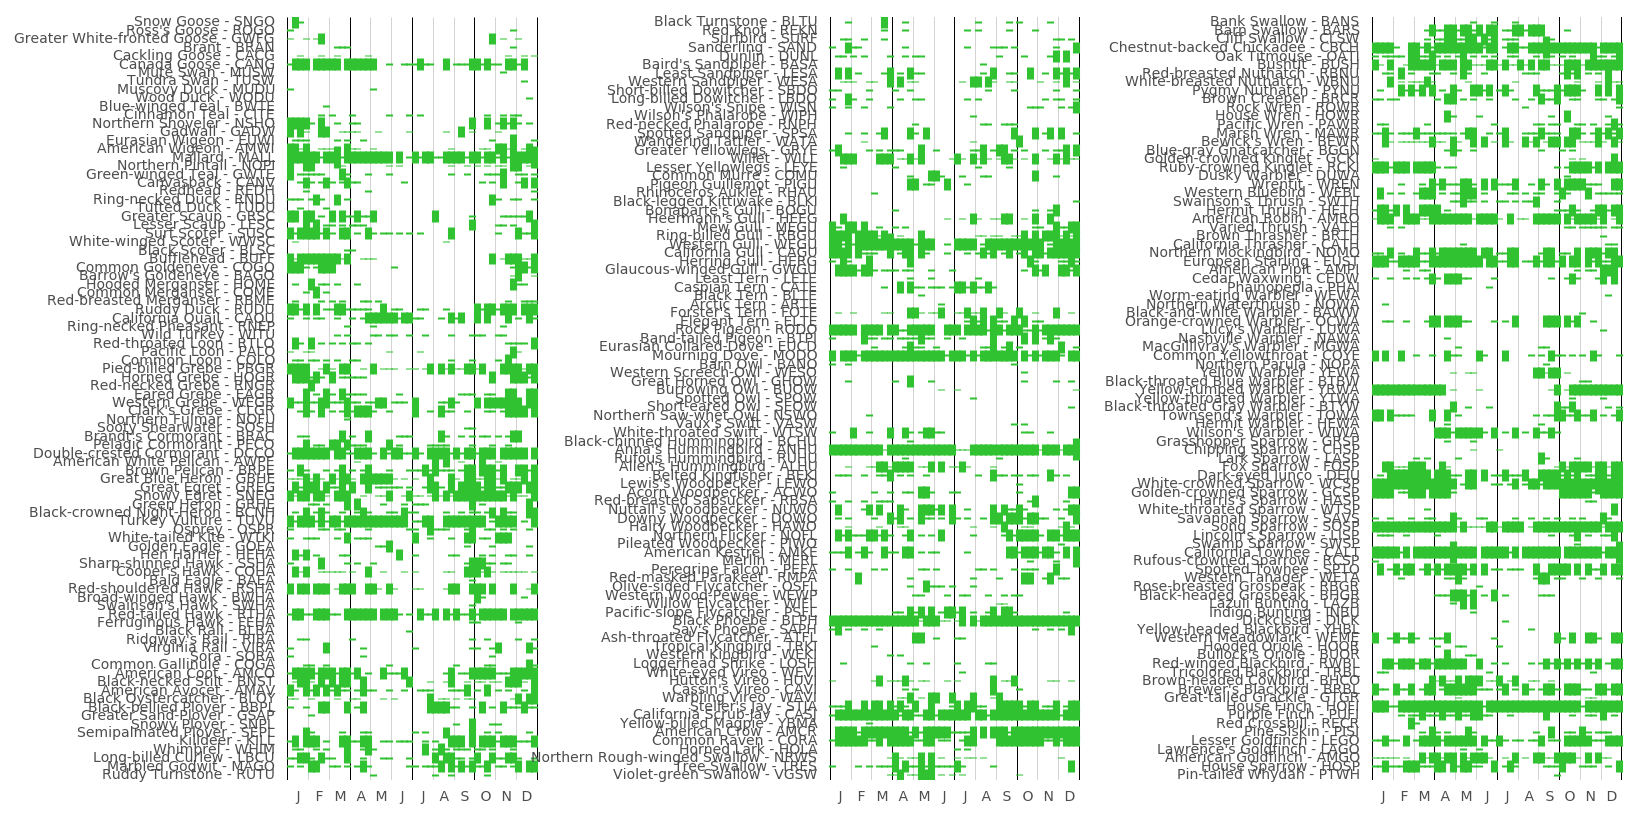

<ggplot: (327108644)>

In [ ]:
# Plot barcharts
geohash4s = geohash_pm(1, geohash_encode(37.9, -122, 4))  # Orinda ±1 (includes: SF, Berkeley hills, Mt Diablo, Marin)
(priors_df
    [lambda df: df.geohash4.isin(geohash4s)]
    .pipe(ebird_species_probs, groupby=['species', 'week'], agg=['geohash4'])
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(plot_barchart,
        # downsample_sp=30,  cols=1, width_per_col=4,    aspect_per_col=1.25,  # Good examle of 1 col
        # downsample_sp=30,  cols=3, width_per_col=14/3, aspect_per_col=0.278, # Great (better than 2 col)
        # downsample_sp=90,  cols=3, width_per_col=14/3, aspect_per_col=0.833, # Great (better than 2 col)
        # downsample_sp=170, cols=3, width_per_col=14/3, aspect_per_col=1.07,  # Great
        # downsample_sp=250, cols=4, width_per_col=5,    aspect_per_col=1.04,  # Great (width 18-22)
        # downsample_sp=300, cols=5, width_per_col=24/5, aspect_per_col=1.00,  # Great (almost full on sp)
        # downsample_sp=415, cols=6, width_per_col=4,    aspect_per_col=1.15,  # Good (room for more sp)
    )
)

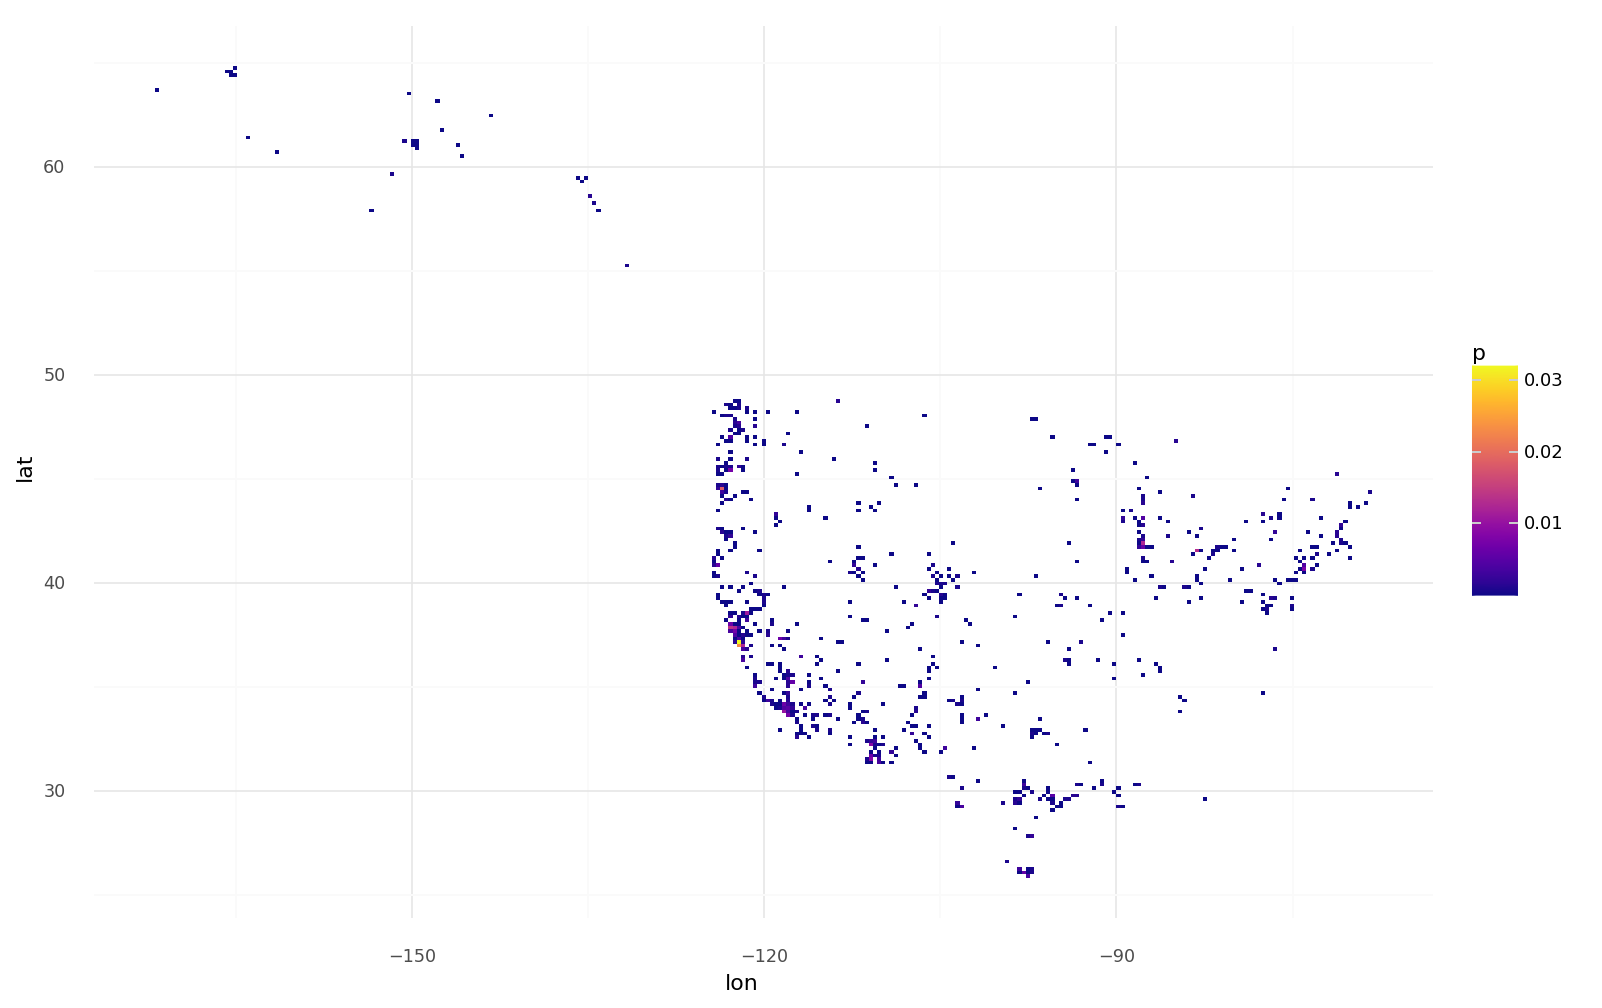

<ggplot: (-9223372036527665285)>

In [ ]:
# Plot species maps
species = ['WIWA']
(priors_df
    [lambda df: df.species.isin(species)]
    .pipe(ebird_species_probs, groupby=['geohash4'], agg=['species', 'week'])
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .assign(
        lat=lambda df: df.geohash4.map(lambda g: geohash.decode(g)[0]),
        lon=lambda df: df.geohash4.map(lambda g: geohash.decode(g)[1]),
        xmin=lambda df: df.geohash4.map(lambda g: geohash.bbox(g)['w']),
        xmax=lambda df: df.geohash4.map(lambda g: geohash.bbox(g)['e']),
        ymin=lambda df: df.geohash4.map(lambda g: geohash.bbox(g)['s']),
        ymax=lambda df: df.geohash4.map(lambda g: geohash.bbox(g)['n']),
    )
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(ggplot)
    + aes(x='lon', y='lat', fill='p', xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax')
    + geom_bin2d(stat='identity')
    + scale_fill_cmap('plasma')
    + theme_minimal()
    + theme_figsize('inline')
)

In [ ]:
# Compute priors[species, p, n] <- (loc, date, priors[ix:week, ix:geohash4, species, n_present, n]
#   - TODO TODO Make this fast enough for model eval (and small enough for serving)
week = ebird_week(date.today())
geohash4 = geohash_encode(37.9, -122, 4)  # Orinda (includes: SF, Berkeley hills, Mt Diablo, Marin)
(week_radius, geohash4_radius) = (1, 1)
_ = (priors_df
    .pipe(ebird_species_probs, week, geohash4, week_radius, geohash4_radius, groupby=['species'], agg=['week', 'geohash4'])
    # Inspect
    .pipe(df_inspect, lambda df: (
        df.nunique(),
        df.sample(n=15, random_state=0).sort_values('species'),
    ))
)

species      101
n_present     10
n              1
p             10
dtype: int64

,species,n_present,n,p
86,TUVU,2,268,0.007
16,BNST,1,268,0.004
13,BLOY,3,268,0.011
55,MAGO,4,268,0.015
78,RUTU,1,268,0.004
94,WESA,4,268,0.015
96,WILL,5,268,0.019
54,LEYE,1,268,0.004
93,WEGU,8,268,0.030
53,LETE,1,268,0.004


In [ ]:
DEBUGGING_BELOW

In [ ]:
%%prun -l50 -scumtime
# %%snakeviz
# Can we optimize assign-by-index? [Haven't found anything faster yet...]
# sample = 0.04
# sample = 0.02
# sample = 0.01
sample = 0.004
display(
    dd.read_parquet(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-{sample}')
    .pipe(df_inspect, lambda ddf: 'npartitions: %s' % ddf.npartitions)
    # .head(1_000, compute=False)
    .map_partitions(lambda df: (df

        # XXX Compat
        .set_index('dist_key')

        # Drop duplicate rows since all (checklist, species) should be unique
        #   - sample=0.001: 142k -> 98.7k rows
        #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
        #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- definitely junk
        .drop_duplicates(
            subset=['week', 'geohash4', 'scientific_name', 'checklist_id'],
            keep='first',
        )

        # Compute n (window)
        #   - Num unique checklist_id's per (week, geohash4)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much

        # Bottleneck: assign-by-index (way slower than the groupby for n_present)
        .reset_index()  # dist_key, from ddf.map_partitions
        .set_index(['dist_key', 'week', 'geohash4'])
        .assign(n=lambda df: (df
            .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
            .checklist_id.nunique()
            .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
        ))
        # .sort_index()  # XXX Debug

        # # .groupby().transform()? [nope, way slower]
        # .pipe(df_inspect, lambda df: 'all: %s' % len(df))
        # .sort_values(['dist_key', 'week', 'geohash4'])
        # [:100]
        # .pipe(df_inspect, lambda df: '[:100]: %s' % len(df))
        # .reset_index()
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # # .checklist_id.nunique()
        # .pipe(df_inspect, lambda df: 'groupby: %s' % len(df))
        # .transform('nunique')
        # .pipe(df_inspect, lambda df: 'transform: %s' % len(df))
        # .head(2)
        # .pipe(df_inspect, lambda df: 'head: %s' % len(df))
        # # [:1]
        # # .transform

        # # .groupby().transform()? [nope, way slower]
        # .sort_values(['dist_key', 'week', 'geohash4'])
        # [:100]
        # .reset_index()
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # # .checklist_id.nunique()
        # .transform({'checklist_id': np.max})
        # .head(2)
        # # [:1]
        # # .transform

        # # .assign on a simple RangeIndex instead of the rich ['dist_key', 'week', 'geohash4'] index? [nope, can't make it work]
        # # .pipe(df_inspect, 'in', lambda df: df[:1])
        # .reset_index()  # dist_key, from ddf.map_partitions
        # # .pipe(df_inspect, 'reset_index', lambda df: df[:1])
        # .assign(n=lambda df: (df
        #     .reset_index()  # RangeIndex -> .index
        #     .pipe(df_inspect, 'reset_index_1', lambda x: x[:3])
        #     .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        #     .pipe(df_inspect, 'groupby', lambda g: next(iter(g))[-1][:3])
        #     .checklist_id.nunique()
        #     .pipe(df_inspect, 'nunique', lambda x: x[:3])
        #     # .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     .reset_index().checklist_id
        #     .pipe(df_inspect, 'reset_index_2', lambda x: x[:3])
        # ))
        # # .pipe(df_inspect, 'assign', lambda df: df[:1])
        # .set_index(['dist_key', 'week', 'geohash4'])
        # .sort_index()  # XXX Debug

        # # Do less in .assign? [nope, nothing to remove]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .set_index(['dist_key', 'week', 'geohash4'])
        # # .sort_index()  # XXX Debug
        # .assign(n=lambda df: (df
        #     .groupby(sort=False, observed=True, by=['dist_key', 'week', 'geohash4'])
        #     .checklist_id.nunique()
        #     # .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     # .pipe(df_inspect, 'other', lambda df: df.to_frame()[:1])
        # ))
        # # .sort_index()  # XXX Debug

        # # .join instead of .assign? [nope, as fast but no faster than assign-by-index above]
% {time: 4.503s}
       # .reset_index()  # dist_key, from ddf.map_partitions
        # .set_index(['dist_key', 'week', 'geohash4'])
        # # .sort_index()  # XXX Debug
        # .pipe(lambda df: (df
        #     # .pipe(df_inspect, 'join', lambda df: df[:1])
        #     .join(how='left', other=(df
        #         .groupby(sort=False, observed=True, by=['dist_key', 'week', 'geohash4'])
        #         .checklist_id.nunique()
        #         .to_frame().rename(columns={'checklist_id': 'n'})
        #         # .pipe(df_inspect, 'other', lambda df: df[:1])
        #         .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     ))
        # ))
        # # .sort_index()  # XXX Debug

        # # .groupby().apply() instead of .assign? [nope, way slower than assign-by-index]
        # # [:10]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # .pipe(df_inspect, 'groupby\ngroupby', lambda g: next(iter(g))[-1][:3])
        # .apply(lambda g: (g
        #     # .assign(n=g.checklist_id.nunique())  # TODO
        # ))
        # .pipe(df_inspect, 'apply\napply', lambda df: df[:3])

        # # .groupby().concat instead of .assign? [nope, way slower than assign-by-index]
        # # [:10]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # .pipe(df_inspect, 'groupby\ngroupby', lambda g: next(iter(g))[-1][:3])
        # .pipe(lambda gs: pd.concat(
        #     g
        #     # g.assign(n=g.checklist_id.nunique())  # TODO
        #     for ix, g in gs
        # ))

        # # Disable, since this isn't the bottleneck
        # # Compute n_present (group)
        # #   - Num checklists per (week, geohash4, scientific_name)
        # #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        # .assign(n_present=1)  # One per (week, geohash4, scientific_name, checklist_id)
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4', 'scientific_name'])
        # .agg({
        #     'n_present': 'sum',
        #     # 'n': 'first',  # Passthru; assume unique per group
        #     # Drop: checklist_id
        # })

    ))
    .compute(
        get=dask_get_for_scheduler('synchronous'),  # Debug
        # get=dask_get_for_scheduler('threads'),  # Faster
        # get=dask_get_for_scheduler('processes'),
    )

    .pipe(df_inspect, len, lambda df: df.reset_index().dtypes.to_frame().T)
    # .query('n_present > 1')
    [:30]
)